# Disease Spread

With the outbreak of the *coronavirus* (COVID-19) in late 2019 and early 2020 there has been an increased interest in modeling the impacts of epidemic and pandemic. Live organisms, and particularly human beings, interact in cmplex ways and are highly dynamic, so trying to capture every movement, every surface touched, every contact between two or more individuals for every human being seems impossible. 

However, with the increasing number of georeferenced information about our commuting patterns, traffic congestions, maps of roads and subways, population demographics, improved weather observation and forecasts, and overall knowledge about human activity simulations are becoming increasingly more detailed.

Incorporating these and many more variables, even for a small country, could take substantil computing power and an interdisciplinary group of scientists. In this exercise we will implement a simplistic simulation to analyze the impact of few paramters on the spread of a made-up disease within an arbitrary small population. We will take into account social distancing and rate at which individuals move. The goal is to learn how to implement simple interactions.

The code below is by no means intended for research use, but it may serve as the basis for creating simple models with few individuals or animals, perhaps something like the spread of a disease within animals in a pasture.


## Ground rules and coding decisions

- Dead people will be masked from computations by assigning a value of NaN (using `np.nan`).

- During the computation of distance, self individuals will be assigned a value of Inf (using `np.inf`). 

- The model assumes an establish population with no birth rate.

- The model does not considered the race, age, sex, or physical condition of the individuals.

- At the 14 day mark, all infected people that did not die automatically recover.

- Recovered individuals become immune to the virus and do not become infected again, even if they interact with an infected individual multiple times during the simulation.

- There is no "bouncing" when there is contact with another individual as in the original simulation by Stevens. Individuals in this version only change direction when they hit an edge.

- People can die after the 10 day of being infected. This is a proxy for leaving the 




## Inspiration

The code implemented in this notebook was inspired by an article published in the Washington post about a made-up illness called simulities written by Harry Stevens (see references for more details). The code is not an exact replica of the simulation in the article by Stevens, but my own interpretation, where I aimed for simplicity so that new coders with some handle of Python can understand the flow of the code.


In [8]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)


In [9]:
# Define function to compute euclidean distance between individuals
def edist(x,y):
    df = np.kron(np.ones(N),[x,y]) - np.kron([x,y],np.ones(N)) # Compute differences using Kronecker product
    E = np.sqrt(df[0]**2 + df[1]**2) # Compute Euclidean distance.
    E = np.reshape(E,[N,N])
    return E


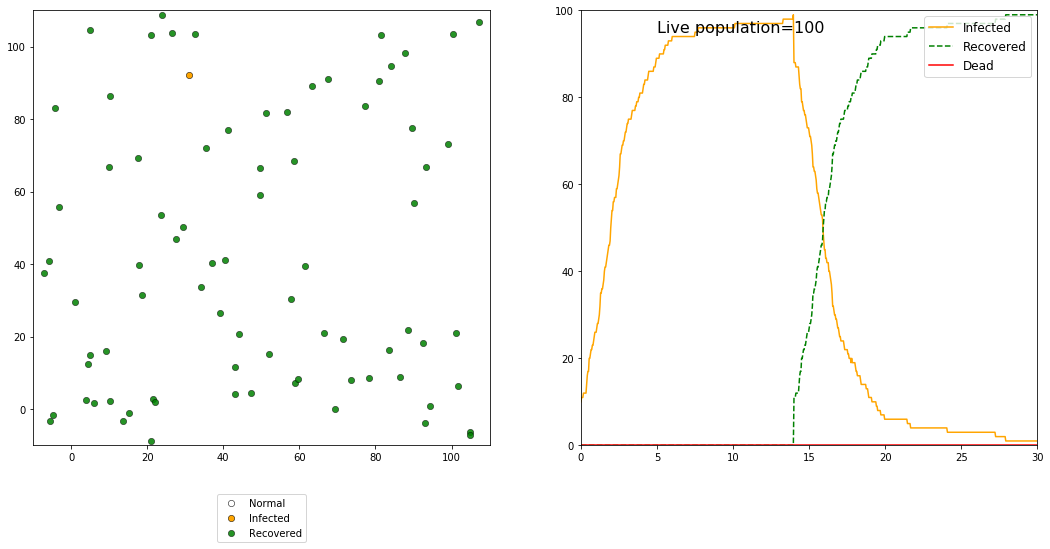

In [15]:
# Simulation space constraints
xmin = 0      # Left system boundary
xmax = 100    # Right system boundary
ymin = 0      # Lower system boundary
ymax = 100    # Upper system boundary

# Simulation time constraints
dt_ = 1/24     # Fraction of day
simulation_days = 30 # Number of simulation days
simulation_steps = round(simulation_days/dt_)
time_counter = 0
simulation_time = np.array([0])

# Existing population
N = 100       # Number of live individuals
N_seed = 10   # Individuals infected at the epicenter
live = np.ones(N, dtype=bool)
dead = np.zeros(N, dtype=bool)

# Initial health conditions
normal = np.ones(N, dtype=bool)
infected = np.zeros(N, dtype=bool)
recovered = np.zeros(N, dtype=bool)

# Initial positions and directions of live individuals
x = np.random.uniform(xmin,xmax,N)
y = np.random.uniform(ymin,ymax,N)
theta = np.radians(np.random.uniform(0,360,N))

# Compute percentage of people circulating
speed = 0.1 # rate at which individuals move.
activity_rate = np.ones(N) * speed  
fraction_static = 0  # Change this to keep people static (at home)
static_individuals = np.random.randint(low=0, high=N, size=round(N*fraction_static))
activity_rate[static_individuals] = 0 

# Social distancing
social_distance = 2 # arbitrary units

# Death rate 
death_rate = 2/100

# Initialize quanrentine time for infected individuals
quarentine_time = np.zeros(N)

# Inoculate a small group of individuals
infected_seeds = np.random.randint(low=0, high=N, size=N_seed)
infected[infected_seeds] = True
normal[infected_seeds] = False

# Initialize totals
total_live = live.sum()
total_dead = dead.sum()
total_normal = normal.sum()
total_infected = infected.sum()
total_recovered = recovered.sum()

# Start recursive iteration
for t in range(simulation_steps):
   
    # Track time
    time_counter += dt
    simulation_time = np.append(simulation_time, time_counter)
    
    # Compute next positions of individuals
    x = x + activity_rate * np.cos(theta)
    y = y + activity_rate * np.sin(theta)
    
    # Handle interaction with system boundaries.
    idx_x = (x <= xmin) | (x >= xmax)
    idx_y = (y <= ymin) | (y >= ymax)
    idx_bnd = idx_x | idx_y

    # Change trajectory angle if hit boundary
    theta[idx_bnd] = np.random.uniform(0,360,np.sum(idx_bnd)) # np.abs(theta[idx_bnd] - 45)
    
    # Determine whether two individuals come in contact
    E = edist(x,y)
    E[np.eye(N, dtype='bool')] = np.inf # Set selfs to inf to avoid being selected.
    rows,cols = np.where(E <= social_distance)
    
    # New infected live individuals
    idx_infected = infected[rows] | infected[cols] & ~recovered[rows]
    infected[rows[idx_infected]] = True
    normal[rows[idx_infected]] = False

    # Recovery of infected individuals that reached quarentine
    quarentine_time[infected] += 1
    idx_recovered = quarentine_time == round(14/dt)
    quarentine_time[idx_recovered] = 0
    recovered[idx_recovered] = True
    normal[idx_recovered] = False
    infected[idx_recovered] = False

    # Remove dead individuals from population
    idx_potential_dead = infected & (quarentine_time == round(14/dt))
    daily_probability_dead = np.random.rand(N)
    daily_probability_dead[~idx_potential_dead] = 0 # Unnecessary line, but left for completeness and logic
    idx_dead = daily_probability_dead >= (1-death_rate)
    dead[idx_dead] = True
    
    # Update live population counts
    live[idx_dead] = False
    infected[idx_dead] = False
    recovered[idx_dead] = False
    normal[idx_dead] = False
    
    # Convert positions of dead individuals to NaN
    #quarentine_time[idx_recovered] = np.nan
    x[idx_dead] = np.nan
    y[idx_dead] = np.nan
    theta[idx_dead] = np.nan
    
    # Compute totals
    total_live = np.append(total_live, live.sum())
    total_dead = np.append(total_dead, dead.sum())
    total_normal = np.append(total_normal, normal.sum())
    total_infected = np.append(total_infected, infected.sum())
    total_recovered = np.append(total_recovered, recovered.sum())
    
    # Plot chart with current positions and health
    plt.figure(figsize=(18,8))
    clear_output(wait=True)
    plt.subplot(1,2,1)
    plt.scatter(x[normal],y[normal],s=40, marker='o',facecolor='w',edgecolor='k', linewidth=0.5, label='Normal')
    plt.scatter(x[infected],y[infected],s=40,marker='o',facecolor='orange',edgecolor='k',linewidth=0.5,label='Infected')
    plt.scatter(x[recovered],y[recovered],s=40,marker='o',facecolor='green',edgecolor='k',linewidth=0.5, alpha=0.85, label='Recovered')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    
    # Set limits of the plot to improve rendering at the boundaries
    plt.xlim(xmin-10,xmax+10)
    plt.ylim(ymin-10,ymax+10)
    
    # Plot progression of health condition
    plt.subplot(1,2,2)
    plt.plot(simulation_time,total_infected, linestyle='-', color='orange',label='Infected')
    plt.plot(simulation_time,total_recovered, '--g',label='Recovered')
    plt.plot(simulation_time,total_dead, '-r',label='Dead')
    plt.xlim(0,simulation_days)
    plt.ylim(0,N)
    plt.legend(loc='upper right', fontsize=12)
    plt.annotate("Live population=" + str(live.sum()), xy=(5,N-5), size=16)
    #plt.legend(loc='upper right',bbox_to_anchor=(1.5,1), fontsize=14)
    #plt.annotate("Live population="+str(live.sum()), xy=(T+10,N/2.5), annotation_clip=False)
    plt.show()
    

## References

"Why outbreaks like coronavirus spread exponentially, and how to flatten the curve" by Harry Stevens. Published on March 14, 2020 by the Washington Post. [Full story](https://www.washingtonpost.com/graphics/2020/world/corona-simulator/).